# Event and Schedule Classes (taken from session 3)

In [66]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')

# Customer Class (self-made)

In [166]:
class Customer:
    '''
    Creating individual customers each time they are added to the system. This allows us to store data
    about them so that we can calculate average waiting times
    
    The arrival_time attribute stores when the customer joined a queue
    The departure_time attribute stores when the customer is done being served
    The waiting time attribute stores the total time they were in the system
    '''
    def __init__(self, arrival_time, departure_time):
        
        self.arrival_time = arrival_time
        self.departure_time = departure_time
        self.waiting_time = self.departure_time - self.arrival_time

# Queue and Grocery store class (modified code from session 3)

In [167]:
import scipy.stats as sts
import random
import numpy as np

class Queue:
    '''
    Creating a queue class that will allow us to serve customers when they join this queue.
    '''
    def __init__(self, service_distribution, queue_number, function, text):
        #store the distribution that represents the time taken to serve customers
        self.service_distribution = service_distribution
        
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.someone_being_served = False
        
        #the number assigned to this queue since we will have many of them
        self.queue_number = queue_number
        
        #a function that will come in handy for the manager implementation
        self.function = function
        
        #storing when customers arrive and leave
        self.customers_arrival_times = []
        self.customers_departure_times = []
        
        #storing customers as objects of the Customer class
        self.customers = []
        
        #the maximum length of this queue
        self.max_length = 0
        
        #whether or not we want to print out the schedule
        self.text = text
    
    def __lt__(self, other):
        
        '''
        This allows us to compare to different queues. We say that one queue is less than
        the other based on the number of people in them. This will help us chose which 
        queue to assign each incoming customer
        '''
        return self.people_in_queue < other.people_in_queue
    
    def add_customer(self, schedule):
        #add the customer to the queue and heap push its arrival time
        heapq.heappush(self.customers_arrival_times, schedule.now)
        self.people_in_queue += 1
        
        #check if the current queue size is larger than the largest queue size
        if self.people_in_queue > self.max_length:
            
            #if it is, update the maximum queue length
            self.max_length = self.people_in_queue
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Add customer to queue.  '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
        
        #if no customer is currently being served, this one can be served immediately
        if self.someone_being_served == False:
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        #move the customer from the queue to a server, so the server is busy
        self.people_in_queue -= 1
        self.someone_being_served = True
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Start serving customer. '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
        
        #schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer)
    
    def finish_serving_customer(self, schedule):
        
        #assign a random number to this serving situation
        manager_probability = random.random()
        
        #if the random number is less than 0.05, call the manager
        if manager_probability < 0.05:
            
            #check if the manager is busy by calling the function, which we will define to be the 
            #customer_needs_manager method in the Grocery_store Class
            is_manager_busy = self.function(schedule, self.queue_number)
            
            #if the manager is not busy
            if is_manager_busy == False:

                #remove the customer from the server
                self.someone_being_served = False
                
                if self.text == True:
                    print(
                        f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                        f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
                
                #if there are more people in the queue, serve the next customer
                if self.people_in_queue > 0:
                    schedule.add_event_after(0, self.start_serving_customer)
                
                #heappush the current time to the departure times as the customer is now leaving the system
                heapq.heappush(self.customers_departure_times, schedule.now)
                
                #create a Customer object with popping the smallest customer arrival and departure time (the first
                #customer to join the queue will obviously be the first one to leave)
                self.customers.append(Customer(heapq.heappop(self.customers_arrival_times), heapq.heappop(self.customers_departure_times)))

        
        #if the manager is not needed
        else:
            
            #remove the customer from the server
            self.someone_being_served = False
            
            if self.text == True:
                print(
                    f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                    f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
            
            #if there are more people in the queue, serve the next customer
            if self.people_in_queue > 0:
                schedule.add_event_after(0, self.start_serving_customer)
            
            #heappush the current time to the departure times as the customer is now leaving the system
            heapq.heappush(self.customers_departure_times, schedule.now)
            
            #create a Customer object with popping the smallest customer arrival and departure time (the first
            #customer to join the queue will obviously be the first one to leave)
            self.customers.append(Customer(heapq.heappop(self.customers_arrival_times), heapq.heappop(self.customers_departure_times)))
        

class GroceryStore_MGc():
    '''
    Creating a GroceryStore class that will allow us to store all the queues and add customers to them and implement
    the manager
    '''
    def __init__(self, arrival_distribution, service_distribution, c, text):
        
        #c is the number of queues in this grocery store
        self.c = c
        
        #same as above, do we want to print the schedule?
        self.text = text
        
        #this checks whether or not the manager is currently busy
        self.manager_busy = False
        
        #this checks how many people are waiting for the manager
        self.people_waiting_for_manager = 0
        
        #store the distribution that represents the time taken to serve customers
        self.service_distribution = service_distribution
        
        #store all the queues in a heap so that the one with the least people can easily be popped
        self.queues = [Queue(self.service_distribution, i+1, self.customer_needs_manager, self.text) for i in range(c)]
        
        #store the distribution that represents the inter-arrival time of customers
        self.arrival_distribution = arrival_distribution
        
        #store the distributions that represents the time taken for the manager to serve a customer
        self.manager_distribution = sts.norm(4, 1)
        
        #the queue the manager is currently helping at
        self.queue_manager_is_at = None
        
        #the number of queues that are currently empty
        self.number_of_empty_queues = []
        
    def add_customer(self, schedule):
        
        # Find the shortest queue
        chosen_queue = heapq.heappop(self.queues)
        
        # Add this customer to the queue
        chosen_queue.add_customer(schedule)
        
        # Push the queue back into the heap of queues
        heapq.heappush(self.queues, chosen_queue)
        
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        
        #initialize a variable that will count the number of empty queues
        empty_queues = 0
        
        #check every queue and if it is empty, increment empty_queues by 1
        for queue in self.queues:
            
            if queue.people_in_queue == 0:
                empty_queues += 1
        
        #append the number of empty queues to the appropriate attribute of the class
        self.number_of_empty_queues.append(empty_queues)
        
    def customer_needs_manager(self, schedule, queue_number):
        
        #update where the manager is at
        self.queue_manager_is_at = queue_number
        
        #increment the number of people waiting for the manager
        self.people_waiting_for_manager += 1
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Customer in queue {queue_number} needs the manager.  '
                f' 🧍🏾‍♀️People waiting for the manager: {self.people_waiting_for_manager}'
                f' Is the manager busy?: {self.manager_busy}')
        
        #check if the manager is busy
        if self.manager_busy == False:
            
            #if he is not, schedule when he will start serving as now
            schedule.add_event_after(0, self.manager_starts_serving)
            
            #return the fact that the manager is not busy (for the finish_serving_customer method in the Queue class)
            return False
            
        else:
            #return the fact that he is busy (for the finish_serving_customer method in the Queue class)
            return True
        
            
    def manager_starts_serving(self, schedule):
        
        #bring the manager over
        self.people_waiting_for_manager -= 1
        self.manager_busy = True
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Manager comes over to help serve customer. '
                f' 🧍🏾‍♀️People waiting for the manager: {self.people_waiting_for_manager}')
        
        #schedule when the manager will be done with the customer
        schedule.add_event_after(
            self.manager_distribution.rvs(),
            self.manager_finishes_serving)
    
    def manager_finishes_serving(self, schedule):
        
        #remove the customer from the manager
        self.manager_busy = False
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Manager finished helping.  ')
        
        #if more people are waiting for the manager
        if self.people_waiting_for_manager > 0:
            
            #check every queue
            for queue in self.queues:
                
                #find the queue the manager just helped
                if queue.queue_number == self.queue_manager_is_at:
                    
                    #the manager is done with that customer so they leave and now
                    #no one is currently being served
                    queue.someone_being_served = False
                    
            #call the manager over to the next customer
            schedule.add_event_after(0, self.manager_starts_serving)
            
    def run(self, schedule):
        #schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
    
    def find_average_waiting_time(self):
        
        #initialize a list
        all_waiting_times = []
        
        #check every queue
        for queue in self.queues:
            
            #check every customer that was ever in that queue
            for customer in queue.customers:
                
                #append their waiting time to our list
                all_waiting_times.append(customer.waiting_time)
        
        #return the mean of all the waiting times
        return np.mean(all_waiting_times)
    
    def get_max_queue_length(self):
        
        #initialize the maximimum queue length
        max_queue_length = 0 
        
        #find the maximum length out of every single queue's maximum
        for queue in self.queues:
            
            if queue.max_length > max_queue_length:
                max_queue_length = queue.max_length
        
        return max_queue_length
    
    def check_arrival_distribution(self):
        
        #initialize a list
        arrivals = []
        
        #check every customer in every queue
        for queue in self.queues:
            
            for customer in queue.customers:
                
                #append when the customer arrived
                arrivals.append(customer.arrival_time)
            
            #append all the arrival times (so all the customers who arrived
            #but did not get served yet)
            for arrival in queue.customers_arrival_times:
                arrivals.append(arrival)
        
        return arrivals

# Functions to run the simulation and get a specific output (modified from session 3)

In [168]:
def run_simulation_MGc_waiting_time(arrival_distribution, service_distribution, run_until, c):
    
    #initialize and run the grocery store for run_until hours
    schedule = Schedule()
    grocery_store = GroceryStore_MGc(arrival_distribution, service_distribution, c, False)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    #return average waiting time
    return grocery_store.find_average_waiting_time()

def run_simulation_MGc_queue_length(arrival_distribution, service_distribution, run_until, c):
    
    #initialize and run the grocery store for run_until hours
    schedule = Schedule()
    grocery_store = GroceryStore_MGc(arrival_distribution, service_distribution, c, False)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    #return maximum queue length
    return grocery_store.get_max_queue_length()

def run_simulation_MGc_empty_queues(arrival_distribution, service_distribution, run_until, c):
    
    #initialize and run the grocery store for run_until hours
    schedule = Schedule()
    grocery_store = GroceryStore_MGc(arrival_distribution, service_distribution, c, False)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    #return average number of empty queues
    return np.mean(grocery_store.number_of_empty_queues)

# Theoretical checks

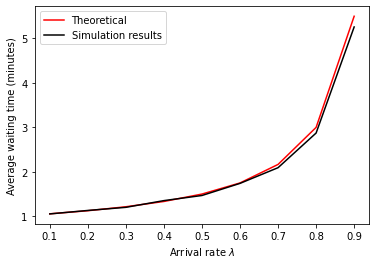

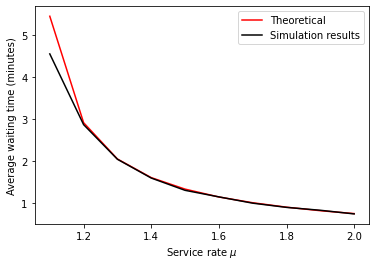

In [16]:
#MD1

import matplotlib.pyplot as plt

lambd = np.linspace(0.1, 0.9, 9)
mu = np.linspace(1.1, 2, 10)

constant_lambd = []
constant_lambd_theoretical = []
constant_mu = []
constant_mu_theoretical = []

for l in lambd:
    
    simulation_result = 0
    for i in range(50):
        simulation_result += run_simulation_MGc_waiting_time(sts.expon(scale = 1/l), sts.norm(1, 0), 9*60, 1)
    
    constant_mu.append(simulation_result/50)
    constant_mu_theoretical.append(1 + l/(2*(1-l)))

plt.plot(lambd, constant_mu_theoretical, color = 'red', label = r'Theoretical')
plt.plot(lambd, constant_mu, color = 'black', label = r'Simulation results')
plt.xlabel(r'Arrival rate $\lambda$')
plt.ylabel(r'Average waiting time (minutes)')
plt.legend()
plt.show()

for m in mu:
    
    simulation_result = 0
    for i in range(50):
        simulation_result += run_simulation_MGc_waiting_time(sts.expon(scale = 1), sts.norm(1/m, 0), 9*60, 1)
    
    constant_lambd.append(simulation_result/50)
    constant_lambd_theoretical.append(1/m + 1/(2*(m)**2 *(1-1/m)))
    
plt.plot(mu, constant_lambd_theoretical, color = 'red', label = r'Theoretical')
plt.plot(mu, constant_lambd, color = 'black', label = r'Simulation results')
plt.xlabel(r'Service rate $\mu$')
plt.ylabel(r'Average waiting time (minutes)')
plt.legend()
plt.show()

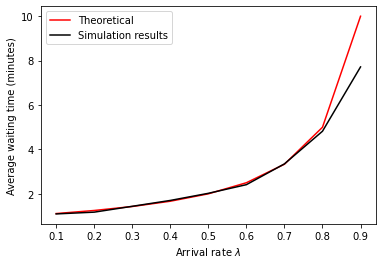

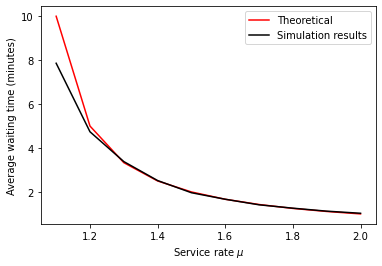

In [17]:
#MM1

lambd = np.linspace(0.1, 0.9, 9)
mu = np.linspace(1.1, 2, 10)

constant_lambd = []
constant_lambd_theoretical = []
constant_mu = []
constant_mu_theoretical = []


for l in lambd:
    
    simulation_result = 0
    for i in range(50):
        simulation_result += run_simulation_MGc_waiting_time(sts.expon(scale = 1/l), sts.expon(scale = 1), 9*60, 1)
    
    constant_mu.append(simulation_result/50)
    constant_mu_theoretical.append(1 + l/(1-l))

plt.plot(lambd, constant_mu_theoretical, color = 'red', label = r'Theoretical')
plt.plot(lambd, constant_mu, color = 'black', label = r'Simulation results')
plt.xlabel(r'Arrival rate $\lambda$')
plt.ylabel(r'Average waiting time (minutes)')
plt.legend()
plt.show()

for m in mu:
    
    simulation_result = 0
    for i in range(50):
        simulation_result += run_simulation_MGc_waiting_time(sts.expon(scale = 1), sts.expon(scale = 1/m), 9*60, 1)
    
    constant_lambd.append(simulation_result/50)
    constant_lambd_theoretical.append(1/m + (1/m)/(m - 1))
    
plt.plot(mu, constant_lambd_theoretical, color = 'red', label = r'Theoretical')
plt.plot(mu, constant_lambd, color = 'black', label = r'Simulation results')
plt.xlabel(r'Service rate $\mu$')
plt.ylabel(r'Average waiting time (minutes)')
plt.legend()
plt.show()

# Results

Text(0, 0.5, 'Average waiting time')

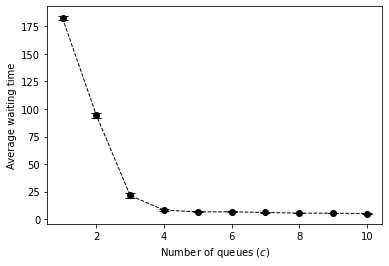

In [171]:
#Average waiting time

number_of_queues = [i for i in range(1, 11)]
avg_waiting_time = []
error = []

for c in number_of_queues:
    
    all_results = []
    
    for j in range(100):
        all_results.append(run_simulation_MGc_waiting_time(sts.expon(scale = 1), sts.norm(3, 1**2), 9*60, c))
    
    t = sts.sem(all_results)
    error.append(1.96*t)
    avg_waiting_time.append(np.mean(all_results))

plt.errorbar(
    number_of_queues, avg_waiting_time, error,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(r'Number of queues ($c$)')
plt.ylabel(r'Average waiting time')

Text(0, 0.5, 'Maximum queue length')

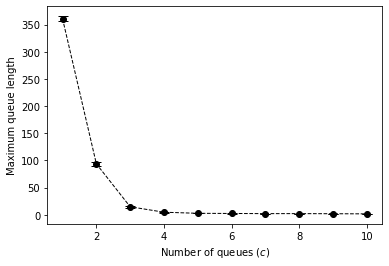

In [72]:
#Maximum queue length

number_of_queues = [i for i in range(1, 11)]
max_queue_length = []
error = []

for c in number_of_queues:
    
    all_results = []
    
    for j in range(100):
        all_results.append(run_simulation_MGc_queue_length(sts.expon(scale = 1), sts.norm(3, 1**2), 9*60, c))
    
    t = sts.sem(all_results)
    error.append(1.96*t)
    max_queue_length.append(np.mean(all_results))

plt.errorbar(
    number_of_queues, max_queue_length, error,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(r'Number of queues ($c$)')
plt.ylabel(r'Maximum queue length')

Text(0, 0.5, 'Number of empty queues on average')

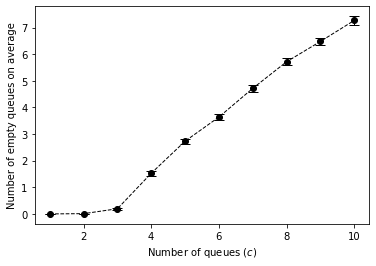

In [75]:
#Number of empty queues on average

number_of_queues = [i for i in range(1, 11)]
empty_queues = []
error = []

for c in number_of_queues:
    
    all_results = []
    
    for j in range(100):
        all_results.append(run_simulation_MGc_empty_queues(sts.expon(scale = 1), sts.norm(3, 1**2), 9*60, c))
    
    t = sts.sem(all_results)
    error.append(1.96*t)
    empty_queues.append(np.mean(all_results))

plt.errorbar(
    number_of_queues, empty_queues, error,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(r'Number of queues ($c$)')
plt.ylabel(r'Number of empty queues on average')

In [76]:
#checking the values since the y axis scale is large and we can't really tell exactly what they are from just looking
#at the graph
print(avg_waiting_time)
print(max_queue_length)
print(empty_queues)

[181.71337542954043, 91.50818598627421, 21.588336891495636, 8.14083066666965, 6.810787051414045, 6.306708870665414, 5.836621081259175, 5.7349539571826975, 5.435820147020824, 5.245966416668052]
[360.86, 93.59, 14.58, 4.53, 2.53, 2.22, 1.93, 1.95, 1.75, 1.5]
[0.0, 0.009987476544579942, 0.19408655428827412, 1.5270287541108842, 2.7305875970358784, 3.6367012343853147, 4.713263025866262, 5.712557607648481, 6.475424153708705, 7.263533739605024]


# Checking arrival times

Text(0.5, 0, 'Time (minutes)')

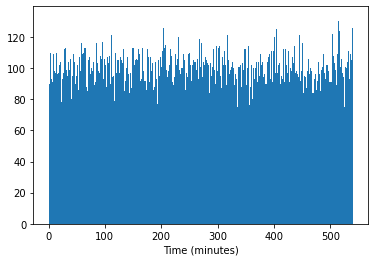

In [78]:
#Quick check that arrival times are indeed a poisson process

def run_simulation_MGc_arivals(arrival_distribution, service_distribution, run_until, c):
    
    #initialize and run the grocery store for run_until hours
    schedule = Schedule()
    grocery_store = GroceryStore_MGc(arrival_distribution, service_distribution, c, False)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    #return all the arrivals
    return grocery_store.check_arrival_distribution()

all_arrivals = []

for i in range(100):
    
    arrival_times = run_simulation_MGc_arivals(sts.expon(scale = 1), sts.norm(3, 1**2), 9*60, 1)
    
    for arrival in arrival_times:
        all_arrivals.append(arrival)
        
plt.hist(all_arrivals, bins = int(all_arrivals[-1]))
plt.xlabel('Time (minutes)')

#The distribution is almost uniform which means that the number of people joining a queue is approximately one 
#at every minute which is what we would see with a poisson distribution with lambda = 1

# Optional part (modified code from session 3)

In [79]:
import scipy.stats as sts
import random

class Customer:
    '''
    Creating individual customers each time they are added to the system. This allows us to store data
    about them so that we can calculate average waiting times and find out what their serving distribution
    looks like based on the number of items they purchase
    
    The number of items attribute uniformly randomly assigns them with between 1 to 30 items
    The arrival_time attribute stores when the customer joined a queue
    The departure_time attribute stores when the customer is done being served
    The number attribute represents the order in which they joined the queue
    '''
    def __init__(self):
        
        self.number_of_items = random.randrange(1, 30)
        self.arrival_time = 0
        self.departure_time = 0
        self.number = 0
    
    def __lt__(self, other):
        
        '''
        This allows us to compare to different customer. We say that one customer is less than
        the other based on their assigned number.
        '''
        return self.number < other.number
    
    def service_distribution(self):
        
        #define their service distribution based on the number of items
        #they bought
        return sts.norm(1 + 0.1*self.number_of_items, 0.5)
    
    def waiting_time(self):
        
        #define their waiting time as the difference between when they arrived and left the store
        return self.departure_time - self.arrival_time
        
        
class Express_Queue:
    '''
    Creating an express queue class that will allow us to serve customers when they join this queue.
    '''
    def __init__(self, queue_number, function, text):
        # We start with an empty queue and no one is being served
        self.people_in_queue = 0
        self.people_being_served = 0
        
        #the number assigned to this queue since we will have many of them
        self.queue_number = queue_number
        
        #a function that will come in handy for the manager implementation
        self.function = function

        #storing when customers arrive and leave
        self.customers_arrival_times = []
        self.customers_departure_times = []

        #storing customers as objects of the Customer class
        self.customers = []

        #the maximum length of this queue
        self.max_length = 0
    
        #whether or not we want to print out the schedule
        self.text = text
        
        #storing who has left this queue
        self.customers_who_have_left = []
        
        #this is an express queue and we need to differentiate it from others
        self.queue_type = 'e'
    
    def __lt__(self, other):
        
        '''
        This allows us to compare to different queues. We say that one queue is less than
        the other based on the number of people in them. This will help us chose which 
        queue to assign each incoming customer
        '''
        return self.people_in_queue < other.people_in_queue
    
    def add_customer(self, schedule, customer):
        #add the customer to the queue and assign them a number 
        #based on how many people are in the queue
        customer.number = len(self.customers)
        heapq.heappush(self.customers, customer)
        self.people_in_queue += 1
        
        check if the current queue size is larger than the largest queue size
        if self.people_in_queue > self.max_length:
            
            #if it is, update the maximum queue length
            self.max_length = self.people_in_queue
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Add customer to queue.  '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
    
        #if less than 4 customers are currently being served, this one can be served immediately
        if self.people_being_served < 4:
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        #move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Start serving customer. '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
        
        #schedule when the server will be done with the customer
        service_distribution = self.customers[0].service_distribution()
        schedule.add_event_after(
            service_distribution.rvs(),
            self.finish_serving_customer)
    
    def finish_serving_customer(self, schedule):
        
        #assign a random number to this serving situation
        manager_probability = random.random()
        
        #if the random number is less than 0.05, call the manager
        if manager_probability < 0.05:
            
            #check if the manager is busy by calling the function, which we will define to be the 
            #customer_needs_manager method in the Grocery_store Class
            is_manager_busy = self.function(schedule, self.queue_number, self.queue_type)
            
            #if the manager is not busy
            if is_manager_busy == False:

                #remove the customer from the server
                self.people_being_served -= 1
                
                #assign the least recent customer that has joined the queue as the leaving customer
                leaving_customer = heapq.heappop(self.customers)
                
                if self.text == True:
                    print(
                        f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                        f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
                
                #update the leaving customer's departure time
                leaving_customer.departure_time = schedule.now
                
                #append this customer to the list of people who have left the store
                self.customers_who_have_left.append(leaving_customer)
                
                if self.people_in_queue > 0:
                    #there are more people in the queue so serve the next customer
                    schedule.add_event_after(0, self.start_serving_customer)
                    
        else:
            
            #remove the customer from the server
            self.people_being_served -= 1

            #assign the least recent customer that has joined the queue as the leaving customer
            leaving_customer = heapq.heappop(self.customers)
            
            if self.text == True:
                print(
                    f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                    f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')

            if self.people_in_queue > 0:
                #there are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer)
                
            #update the leaving customer's departure time
            leaving_customer.departure_time = schedule.now

            #append this customer to the list of people who have left the store
            self.customers_who_have_left.append(leaving_customer)
        
        
        
class Regular_Queue:
    def __init__(self, queue_number, function, text):
        # We start with an empty queue and no one is being served
        self.people_in_queue = 0
        self.people_being_served = 0
        
        #the number assigned to this queue since we will have many of them
        self.queue_number = queue_number
        
        #a function that will come in handy for the manager implementation
        self.function = function

        #storing when customers arrive and leave
        self.customers_arrival_times = []
        self.customers_departure_times = []

        #storing customers as objects of the Customer class
        self.customers = []

        #the maximum length of this queue
        self.max_length = 0
    
        #whether or not we want to print out the schedule
        self.text = text
        
        #storing who has left this queue
        self.customers_who_have_left = []
        
        #this is a regular queue and we need to differentiate it from others
        self.queue_type = 'r'
    
    def __lt__(self, other):
        
        '''
        This allows us to compare to different queues. We say that one queue is less than
        the other based on the number of people in them. This will help us chose which 
        queue to assign each incoming customer
        '''
        return self.people_in_queue < other.people_in_queue
    
    def add_customer(self, schedule, customer):
        #add the customer to the queue and assign them a number based
        #on how many customers are currently in the queue
        customer.number = len(self.customers)
        heapq.heappush(self.customers, customer)
        self.people_in_queue += 1
        
        #check if the current queue size is larger than the largest queue size
        if self.people_in_queue > self.max_length:
            
            #if it is, update the maximum queue length
            self.max_length = self.people_in_queue
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Add customer to queue.  '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
        
        if self.people_being_served < 1:
            #this customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        #move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Start serving customer. '
                f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
        
        #schedule when the server will be done with the customer
        service_distribution = self.customers[0].service_distribution()
        schedule.add_event_after(
            service_distribution.rvs(),
            self.finish_serving_customer)
    
    def finish_serving_customer(self, schedule):
        
        #assign a random number to this serving situation
        manager_probability = random.random()
        
        #if the random number is less than 0.05, call the manager
        if manager_probability < 0.05:
            
            #check if the manager is busy by calling the function, which we will define to be the 
            #customer_needs_manager method in the Grocery_store Class
            is_manager_busy = self.function(schedule, self.queue_number, self.queue_type)
            
            #if the manager is not busy
            if is_manager_busy == False:

                #remove the customer from the server
                self.people_being_served -= 1
                
                #assign the least recent customer that has joined the queue as the leaving customer
                leaving_customer = heapq.heappop(self.customers)
                
                if self.text == True:
                    print(
                        f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                        f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')
                    
                #update the leaving customer's departure time
                leaving_customer.departure_time = schedule.now
                
                #append this customer to the list of people who have left the store
                self.customers_who_have_left.append(leaving_customer)
                
                if self.people_in_queue > 0:
                    #there are more people in the queue so serve the next customer
                    schedule.add_event_after(0, self.start_serving_customer)
                    
        else:
            
            #remove the customer from the server
            self.people_being_served -= 1
            
            #assign the least recent customer that has joined the queue as the leaving customer
            leaving_customer = heapq.heappop(self.customers)
            
            if self.text == True:
                print(
                    f'⏱{schedule.now:5.2f}min: Stop serving customer.  '
                    f' 🧍🏾‍♀️People in queue number {self.queue_number}: {self.people_in_queue}')

            if self.people_in_queue > 0:
                #there are more people in the queue so serve the next customer
                schedule.add_event_after(0, self.start_serving_customer)
            
            #update the leaving customer's departure time
            leaving_customer.departure_time = schedule.now
            
            #append this customer to the list of people who have left the store
            self.customers_who_have_left.append(leaving_customer)
        

class GroceryStore_MGc:
    '''
    Creating a GroceryStore class that will allow us to store all the queues and add customers to them and implement
    the manager
    '''
    def __init__(self, arrival_distribution, c, k, text):
        
        #c is the number of queues in this grocery store
        self.c = c
        
        #same as above, do we want to print the schedule?
        self.text = text
        
        #this checks whether or not the manager is currently busy
        self.manager_busy = False
        
        #this checks how many people are waiting for the manager
        self.people_waiting_for_manager = 0
        
        #store all the regular and express queues
        self.regular_queues = [Regular_Queue(i+1, self.customer_needs_manager, self.text) for i in range(c)]
        self.express_queues = [Express_Queue(i+1, self.customer_needs_manager, self.text) for i in range(k)]
        
        #store the distribution that represents the inter-arrival times of customers
        self.arrival_distribution = arrival_distribution
        
        #store the distributions that represents the time taken for the manager to serve a customer
        self.manager_distribution = sts.norm(4, 1)
        
        #the queue the manager is currently helping at
        self.queue_manager_is_at = None
        
    def add_customer(self, schedule):
        
        #create a customer and update its arrival time
        current_customer = Customer()
        current_customer.arrival_time = schedule.now
        
        #if it has more than 10 items
        if current_customer.number_of_items > 10:
            # Find the shortest regular queue
            chosen_queue = heapq.heappop(self.regular_queues)

            # Add this customer to the queue
            chosen_queue.add_customer(schedule, current_customer)

            # Push the queue back into the heap of queues
            heapq.heappush(self.regular_queues, chosen_queue)

            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)
        
        else:
            # Find the shortest express queue
            chosen_queue = heapq.heappop(self.express_queues)

            # Add this customer to the queue
            chosen_queue.add_customer(schedule, current_customer)

            # Push the queue back into the heap of queues
            heapq.heappush(self.express_queues, chosen_queue)

            # Schedule when to add another customer
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer)
        
    def customer_needs_manager(self, schedule, queue_number, queue_type):
        
        #update where the manager is at
        self.queue_manager_is_at = [queue_type, queue_number]
        
        #increment the number of people waiting for the manager
        self.people_waiting_for_manager += 1

        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Customer in queue {queue_number} needs the manager.  '
                f' 🧍🏾‍♀️People waiting for the manager: {self.people_waiting_for_manager}'
                f' Is the manager busy?: {self.manager_busy}')
        
        #check if the manager is busy
        if self.manager_busy == False:
            
            #if he is not, schedule when he will start serving as now
            schedule.add_event_after(0, self.manager_starts_serving)
            
            #return the fact that the manager is not busy (for the finish_serving_customer method in the Queue class)
            return False
            
        else:
            #return the fact that he is busy (for the finish_serving_customer method in the Queue class)
            return True
        
            
    def manager_starts_serving(self, schedule):
        
        #bring the manager over
        self.people_waiting_for_manager -= 1
        self.manager_busy = True
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Manager comes over to help serve customer. '
                f' 🧍🏾‍♀️People waiting for the manager: {self.people_waiting_for_manager}')
        
        # Schedule when the manager will be done with the customer
        schedule.add_event_after(
            self.manager_distribution.rvs(),
            self.manager_finishes_serving)
    
    def manager_finishes_serving(self, schedule):
        
        #remove the customer from the manager
        self.manager_busy = False
        
        if self.text == True:
            print(
                f'⏱{schedule.now:5.2f}min: Manager finished helping.  ')
        
        #if more people are waiting for the manager
        if self.people_waiting_for_manager > 0:
            
            #if the manager is at a regular queue
            if self.queue_manager_is_at[0] == 'r':
                    
                    #check all regular queues
                    for queue in self.regular_queues:
                        
                        #find the one the manager just helped at
                        if queue.queue_number == self.queue_manager_is_at:
                            
                            #the manager is done with that customer so they leave and now
                            #no one is currently being served
                            queue.someone_being_served = False
            
            else:
                    #same as above but for express queues
                    for queue in self.express_queues:

                        if queue.queue_number == self.queue_manager_is_at:
                            
                            #the manager is done with that customer so they leave and now
                            #no one is currently being served
                            queue.someone_being_served = False
                    
            #there are more people waiting for the manager so call them over to the next customer
            schedule.add_event_after(0, self.manager_starts_serving)
            
    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
    
    def find_average_waiting_time(self):
        
        #initialize lists
        express_waiting_times = []
        regular_waiting_times = []
        
        #check every regular queue
        for queue in self.regular_queues:
            
            #append to the appropriate list every customer who has left's
            #waiting time
            for customer in queue.customers_who_have_left:
                
                regular_waiting_times.append(customer.waiting_time())
        
        #same as above but for express queues
        for queue in self.express_queues:
            
            for customer in queue.customers_who_have_left:
                
                express_waiting_times.append(customer.waiting_time())
        
        #return the average waiting times for each queue type
        return (np.mean(regular_waiting_times), np.mean(express_waiting_times))

def run_simulation_MGc_with_express(arrival_distribution, run_until, c, k):
    
    #initialize and run the grocery store for run_until hours
    schedule = Schedule()
    grocery_store = GroceryStore_MGc(arrival_distribution, c, k, False)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    
    #return the average waiting times
    return grocery_store.find_average_waiting_time()

In [161]:
#This takes a very long while to run!!!

regular = []
express = []
avg_waiting_time = []
regular_wait = []
express_wait = []
all_values = []

#check all potential number of regular lines
for i in range(1, 11):
    
    #check all potential number of express lines so that there are less than 10 lines in total
    for j in range(1, 11-i):
        
        #store the number of regular lines
        regular.append(i)
        
        #store the number of express lines
        express.append(j)
        
        #find the average wait time for each type of queue in this scenario after 30 times running the simulation
        avg_regular = 0
        avg_express = 0
        for _ in range(30):
            result = run_simulation_MGc_with_express(sts.expon(scale = 1), 540, i, j)
            avg_regular += result[0]/30
            avg_express += result[1]/30
            
        #store the average waiting times
        regular_wait.append(avg_regular)
        express_wait.append(avg_express)
        
        #create a waited average of the waiting time (only 1/3 of customers have less than 10 items and can use
        #the express line)
        avg_waiting_time.append((2*avg_regular+1*avg_express)/3)

In [162]:
#I would like to point out that in my paper I said the optimal was 9 to 1 but the result seems to change
#(I also got 8 to 1) which is probably because the simulation is only being run 30 times because of computational
#constraints. However that does not change the discussion very much anyway!

min_wait_time = min(avg_waiting_time)
array_position_of_min = np.where(avg_waiting_time == min_wait_time)
print(min_wait_time, regular[array_position_of_min[0][0]], express[array_position_of_min[0][0]], regular_wait[array_position_of_min[0][0]], express_wait[array_position_of_min[0][0]])

3.1174234945380697 9 1 3.2373686652779727 2.8775331530582635
